<a href="https://colab.research.google.com/github/yezhengli-Mr9/Blotto-game/blob/master/new1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch, random,glob
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
# import matplotlib as mpl
# mpl.use('Qt4Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import pickle, os, cv2
from tqdm import tqdm
import numpy as np

In [0]:
def rgb2gray(I_rgb):
  r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
  I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return I_gray

In [0]:
%mkdir res
# %ls res/*.txt
%cat res/log_new1*.txt |wc -l
%cat res/log_new1*.txt

mkdir: cannot create directory ‘res’: File exists
150
epoch 1 loss tensor(38.5763, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 0.001 batch_size 100 time 50.094717502593994
epoch 2 loss tensor(28.7998, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 0.001 batch_size 100 time 99.90098667144775
epoch 3 loss tensor(27.5588, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 0.001 batch_size 100 time 149.69241738319397
epoch 4 loss tensor(24.1713, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 0.001 batch_size 100 time 199.477796792984
epoch 5 loss tensor(23.8717, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 0.001 batch_size 100 time 249.25219821929932
epoch 6 loss tensor(21.9005, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 0.001 batch_size 100 time 299.042902469635
epoch 7 loss tensor(20.4823, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 0.001 batch_size 100 time 348.82960844039917
epoch 8 loss tensor(22.2341

In [0]:

# %rm model/deno_autoencoder_circle_new1_scale*epoche_*.pkl
# %rm circle_gts.pkl
# %rm data/*
%rm temp*.png
%mkdir data
%mkdir model
# %mv deno_autoencoder_circle_new_epoche_160.pkl model/deno_autoencoder_circle_new_epoche_160.pkl

rm: cannot remove 'temp*.png': No such file or directory
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘model’: File exists


In [0]:
%ls res/* -alrth|wc -l
# %rm model/deno_autoencoder_circle_new1_scale_*_epoche_*.pkl
%ls model/* -alrth

201
-rw-r--r-- 1 root root 893K Dec  1 19:13 model/deno_autoencoder_circle_new1_scale_002_epoche_010.pkl
-rw-r--r-- 1 root root 893K Dec  1 19:21 model/deno_autoencoder_circle_new1_scale_002_epoche_020.pkl
-rw-r--r-- 1 root root 893K Dec  1 19:29 model/deno_autoencoder_circle_new1_scale_002_epoche_030.pkl
-rw-r--r-- 1 root root 893K Dec  1 19:37 model/deno_autoencoder_circle_new1_scale_002_epoche_040.pkl
-rw-r--r-- 1 root root 893K Dec  1 19:46 model/deno_autoencoder_circle_new1_scale_002_epoche_050.pkl
-rw-r--r-- 1 root root 893K Dec  1 19:56 model/deno_autoencoder_circle_new1_scale_002_epoche_060.pkl
-rw-r--r-- 1 root root 893K Dec  1 20:04 model/deno_autoencoder_circle_new1_scale_002_epoche_070.pkl
-rw-r--r-- 1 root root 893K Dec  1 20:13 model/deno_autoencoder_circle_new1_scale_002_epoche_080.pkl
-rw-r--r-- 1 root root 893K Dec  1 20:21 model/deno_autoencoder_circle_new1_scale_002_epoche_090.pkl
-rw-r--r-- 1 root root 893K Dec  1 20:29 model/deno_autoencoder_circle_new1_scale_002_e

In [0]:
# Set Hyperparameters
epoch = 50
batch_size =100 #100 #256
learning_rate = 1e-5
scale = 2
size = 200
data_amount = (int(8000/batch_size)+1)*batch_size

In [0]:
def print_log(text):
  with open("res/log_new1_scale_{:03d}.txt".format(scale), "a+") as f:
    f.write(text+'\n')
  print(text)

In [0]:
from skimage.draw import circle_perimeter_aa
def draw_circle(img, row, col, rad):
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]

def noisy_circle(size, radius, noise):
    img = np.zeros((size, size), dtype=np.float)
    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)
    # Noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img

gts_imgs = []
imgs = []
fpickle= "circle_gts.pkl"
if os.path.exists(fpickle):
    print("LOADING "+fpickle)
    with open(fpickle,'rb') as fp:
        gts = pickle.load(fp)
    for i in tqdm(range(data_amount)):        
        img =  cv2.imread("data/{:05d}.png".format(i))
        try:
        # img  = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
          img_ = rgb2gray(img)
          img = img_
        except:
          pass

        imgs.append(img[None,:,:])
        params = gts[i]
        temp = np.zeros((size, size), dtype=np.float)
        draw_circle(temp, params[0], params[1], params[2])
#         temp = np.uint8(255*temp)
#         print(temp.shape)
#         print(temp, np.max(temp))
#         temp = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY )
        temp =255* temp/np.max(temp)
        gts_imgs.append(temp[None,:,:])
        
else:
    gts = []
    for i in tqdm(range(data_amount)):
        params, img = noisy_circle(size, 50, 2)
        # print("before", img.shape)
        # img = np.fft.fft2(img) 
        # img = np.fft.ifft2(img) 
        # print(i, np.max(img), np.min(img))
        # img = img - np.min(img)
        img = img *255/  np.max(img)
        try:
        # img  = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
          img_ = rgb2gray(img)
          img = img_
        except:
          pass
        # print("after", img.shape)
        cv2.imwrite("data/{:05d}.png".format(i), img)
        img = cv2.imread("data/{:05d}.png".format(i))
        gts.append(params)
        # img = np.uint8(img)
        # img  = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        img = rgb2gray(img)
        imgs.append(img[None,:,:])
        temp = np.zeros((size, size), dtype=np.float)
        draw_circle(temp, params[0], params[1], params[2])
        temp =255* temp/np.max(temp)
#         temp = cv2.cvtColor(np.uint8(255*temp), cv2.COLOR_RGB2GRAY )
        gts_imgs.append(temp[None,:,:])

    with open(fpickle,'wb') as fp:
        pickle.dump(gts,fp)

  1%|          | 75/8100 [00:00<00:10, 745.14it/s]

LOADING circle_gts.pkl


100%|██████████| 8100/8100 [00:10<00:00, 750.53it/s]


In [0]:
# https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader

tensorImgs = torch.stack([torch.Tensor(img ) for img in imgs[:data_amount-(int(10000/batch_size)+1)*batch_size ]]) # transform to torch tensors
tensorGts = torch.stack([torch.Tensor(gt ) for gt in gts_imgs[:data_amount-(int(10000/batch_size)+1)*batch_size]]) # transform to torch tensors

my_dataset = torch.utils.data.TensorDataset(tensorImgs,tensorGts ) # create your datset
# my_dataloader = utils.data.DataLoader(my_dataset) # create your dataloader
train_loader = torch.utils.data.DataLoader(dataset=my_dataset,batch_size=batch_size,shuffle=True)

In [0]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 1 x 28 x 28 -> batch x 512

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        # nn.Conv2d(32,32,3,padding=1),  # batch x 32 x 28 x 28
                        # nn.ReLU(),
                        # nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        # nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        # nn.MaxPool2d(2,2),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
                
    def forward(self,x):
        # print("[encoder] x.size()",x.size())
        out = self.layer1(x)
        # print("[encoder] 1out.size()",out.size())
        out = self.layer2(out)
        # print("[encoder] out.size()",out.size(), 128*int(size/scale)*int(size/scale), int(size/scale), size, scale)
        out = out.view(-1, 64*int(size/scale)*int(size/scale))
        return out
    
encoder = Encoder().cuda()#cpu()# #yezheng

In [0]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)




# https://zhuanlan.zhihu.com/p/39240159
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# output_size = (input_size-1) * stride + outputpadding -2*padding + kernel_size
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(64,64,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU(),
                        nn.MaxPool2d(4,4)
        )
        
        
    def forward(self,x):
        out = x.view(-1,64,round(size/scale),round(size/scale))
        # print("[decoder] out.size()", out.size())
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()#cpu() #yezheng

In [0]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
print(len(parameters ))
num_parameters = 0
for p in parameters:
  print(p.shape)
  r = 1
  for f in  list(p.shape):
    r*=f
  num_parameters+=r
print(num_parameters)

44
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 3, 3])
torch.Size([1])
223169


In [0]:
# train encoder and decoder
# save and load model
max_epoch = 0
for md_para_save_name in glob.glob('model/deno_autoencoder_circle_new1_scale_{:03d}_epoche_*.pkl'.format(scale)): 
  max_epoch = max(max_epoch,int(md_para_save_name.split('_')[-1][:-4]))
if 0 == max_epoch:
  print("\n--------model not restored--------\n")
else:
  encoder, decoder = torch.load('model/deno_autoencoder_circle_new1_scale_{:03d}_epoche_{:03d}.pkl'.format(scale,max_epoch))
  print("\n--------model restored--------\n")
# 

Half = nn.Upsample(scale_factor=1/scale, mode='bilinear')
Double = nn.Upsample(scale_factor=scale, mode='bilinear')
from time import time
T0 = time()
for i in tqdm(range(max_epoch+1, max_epoch+ epoch+1)):#+ epoch+1
#     List = random.choices(range(1000), k=batch_size)
#     for j in List:
    for image_n,img_gt in train_loader:
#         image_n = torch.tensor(imgs[j])
#         img_gt = torch.tensor(gts_imgs[j])
        # print(image_n.size(), img_gt.size())
        image_n = Half(Variable(image_n).cuda()) #cpu()#yezheng
        img_gt = Half(Variable(img_gt).cuda() ) #cpu() #yezheng        
        #label = Variable(label.float()).cpu()#.cuda() #yezheng
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        # print(output.size(), image_n.size())
        loss = loss_func(output,img_gt)
        loss.backward()
        optimizer.step()
        
                
    if i%10 == 0: 
      torch.save([encoder,decoder],'model/deno_autoencoder_circle_new1_scale_{:03d}_epoche_{:03d}.pkl'.format(scale,i))
      max_epoch = max(max_epoch, i)
    print_log("epoch "+str(i)+" loss "+str(loss)+" learning_rate "+str(learning_rate)+' batch_size '+str(batch_size) + " time "+str(time() - T0))

  0%|          | 0/50 [00:00<?, ?it/s]


--------model restored--------



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
  2%|▏         | 1/50 [00:49<40:48, 49.97s/it]

epoch 151 loss tensor(9.4861, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 49.96876788139343


  4%|▍         | 2/50 [01:39<39:55, 49.90s/it]

epoch 152 loss tensor(9.3843, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 99.71150159835815


  6%|▌         | 3/50 [02:29<39:03, 49.85s/it]

epoch 153 loss tensor(9.4412, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 149.46022033691406


  8%|▊         | 4/50 [03:19<38:12, 49.83s/it]

epoch 154 loss tensor(8.9121, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 199.22005128860474


 10%|█         | 5/50 [04:08<37:21, 49.80s/it]

epoch 155 loss tensor(9.2996, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 248.96967482566833


 12%|█▏        | 6/50 [04:58<36:30, 49.79s/it]

epoch 156 loss tensor(8.3380, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 298.7185573577881


 14%|█▍        | 7/50 [05:48<35:40, 49.78s/it]

epoch 157 loss tensor(8.0928, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 348.4675726890564


 16%|█▌        | 8/50 [06:38<34:50, 49.77s/it]

epoch 158 loss tensor(10.9000, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 398.21156883239746


 18%|█▊        | 9/50 [07:27<34:00, 49.76s/it]

epoch 159 loss tensor(9.2020, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 447.95858335494995


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

epoch 160 loss tensor(9.6062, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 497.697655916214


 22%|██▏       | 11/50 [09:07<32:20, 49.75s/it]

epoch 161 loss tensor(8.5061, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 547.4486668109894


 24%|██▍       | 12/50 [09:57<31:30, 49.75s/it]

epoch 162 loss tensor(9.3661, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 597.2079925537109


 26%|██▌       | 13/50 [10:46<30:40, 49.75s/it]

epoch 163 loss tensor(9.7036, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 646.9580111503601


 28%|██▊       | 14/50 [11:36<29:50, 49.75s/it]

epoch 164 loss tensor(8.2259, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 696.6918528079987


 30%|███       | 15/50 [12:26<29:01, 49.75s/it]

epoch 165 loss tensor(10.3358, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 746.4356360435486


 32%|███▏      | 16/50 [13:16<28:11, 49.75s/it]

epoch 166 loss tensor(8.4637, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 796.1890428066254


 34%|███▍      | 17/50 [14:05<27:21, 49.75s/it]

epoch 167 loss tensor(9.6514, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 845.9336819648743


 36%|███▌      | 18/50 [14:55<26:31, 49.75s/it]

epoch 168 loss tensor(10.1439, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 895.6767346858978


 38%|███▊      | 19/50 [15:45<25:42, 49.74s/it]

epoch 169 loss tensor(8.8910, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 945.4145882129669


 40%|████      | 20/50 [16:35<24:52, 49.75s/it]

epoch 170 loss tensor(10.3311, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 995.1768519878387


 42%|████▏     | 21/50 [17:24<24:02, 49.75s/it]

epoch 171 loss tensor(9.6828, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1044.9297394752502


 44%|████▍     | 22/50 [18:14<23:13, 49.75s/it]

epoch 172 loss tensor(8.9321, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1094.6894042491913


 46%|████▌     | 23/50 [19:04<22:23, 49.75s/it]

epoch 173 loss tensor(9.7077, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1144.4438734054565


 48%|████▊     | 24/50 [19:54<21:33, 49.75s/it]

epoch 174 loss tensor(9.6136, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1194.1916909217834


 50%|█████     | 25/50 [20:43<20:43, 49.75s/it]

epoch 175 loss tensor(9.3380, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1243.9385106563568


 52%|█████▏    | 26/50 [21:33<19:54, 49.75s/it]

epoch 176 loss tensor(8.8476, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1293.7002205848694


 54%|█████▍    | 27/50 [22:23<19:04, 49.76s/it]

epoch 177 loss tensor(8.8518, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1343.4621269702911


 56%|█████▌    | 28/50 [23:13<18:14, 49.75s/it]

epoch 178 loss tensor(10.9086, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1393.206093788147


 58%|█████▊    | 29/50 [24:02<17:24, 49.75s/it]

epoch 179 loss tensor(10.8187, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1442.954469203949


 60%|██████    | 30/50 [24:52<16:35, 49.75s/it]

epoch 180 loss tensor(8.6438, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1492.7070710659027


 62%|██████▏   | 31/50 [25:42<15:45, 49.75s/it]

epoch 181 loss tensor(10.8385, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1542.4693875312805


 64%|██████▍   | 32/50 [26:32<14:55, 49.76s/it]

epoch 182 loss tensor(10.8638, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1592.2275557518005


 66%|██████▌   | 33/50 [27:21<14:05, 49.75s/it]

epoch 183 loss tensor(9.4633, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1641.9683890342712


 68%|██████▊   | 34/50 [28:11<13:16, 49.76s/it]

epoch 184 loss tensor(8.5827, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1691.737431049347


 70%|███████   | 35/50 [29:01<12:26, 49.75s/it]

epoch 185 loss tensor(10.1634, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1741.4843637943268


 72%|███████▏  | 36/50 [29:51<11:36, 49.76s/it]

epoch 186 loss tensor(8.9637, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1791.2457444667816


 74%|███████▍  | 37/50 [30:41<10:46, 49.76s/it]

epoch 187 loss tensor(7.8729, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1841.0085489749908


 76%|███████▌  | 38/50 [31:30<09:57, 49.75s/it]

epoch 188 loss tensor(9.0622, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1890.7495005130768


 78%|███████▊  | 39/50 [32:20<09:07, 49.75s/it]

epoch 189 loss tensor(8.5187, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1940.4940965175629


 80%|████████  | 40/50 [33:10<08:17, 49.75s/it]

epoch 190 loss tensor(9.9913, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 1990.2338149547577


 82%|████████▏ | 41/50 [33:59<07:27, 49.75s/it]

epoch 191 loss tensor(9.0856, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2039.9884929656982


 84%|████████▍ | 42/50 [34:49<06:38, 49.75s/it]

epoch 192 loss tensor(9.5368, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2089.7448115348816


 86%|████████▌ | 43/50 [35:39<05:48, 49.75s/it]

epoch 193 loss tensor(7.9913, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2139.4948732852936


 88%|████████▊ | 44/50 [36:29<04:58, 49.75s/it]

epoch 194 loss tensor(8.8607, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2189.247360944748


 90%|█████████ | 45/50 [37:18<04:08, 49.75s/it]

epoch 195 loss tensor(8.9112, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2238.9971673488617


 92%|█████████▏| 46/50 [38:08<03:18, 49.75s/it]

epoch 196 loss tensor(8.6939, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2288.74347281456


 94%|█████████▍| 47/50 [38:58<02:29, 49.75s/it]

epoch 197 loss tensor(9.0979, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2338.4924187660217


 96%|█████████▌| 48/50 [39:48<01:39, 49.75s/it]

epoch 198 loss tensor(9.8578, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2388.2415931224823


 98%|█████████▊| 49/50 [40:37<00:49, 49.75s/it]

epoch 199 loss tensor(8.4213, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2437.9958012104034


100%|██████████| 50/50 [41:27<00:00, 49.75s/it]

epoch 200 loss tensor(8.2183, device='cuda:0', grad_fn=<MseLossBackward>) learning_rate 1e-05 batch_size 100 time 2487.7517952919006


mkdir: cannot create directory ‘res’: File exists


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 200/200 [00:50<00:00,  4.32it/s]


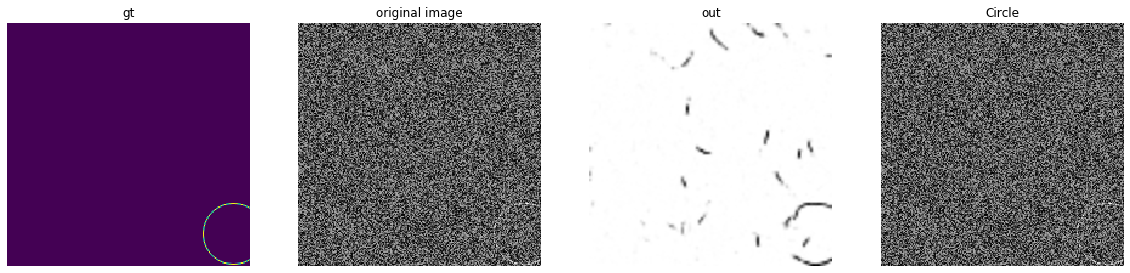

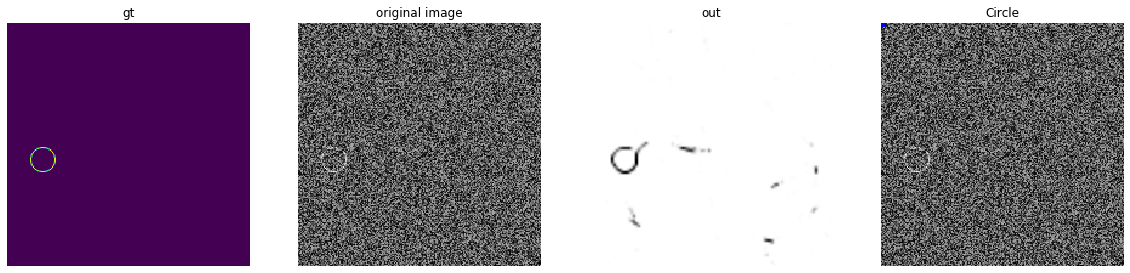

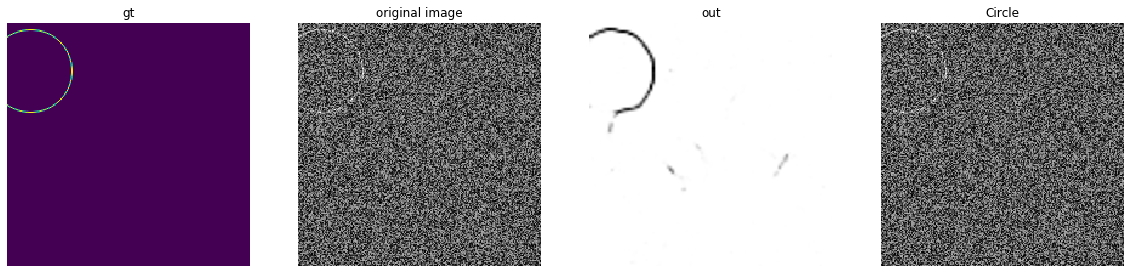

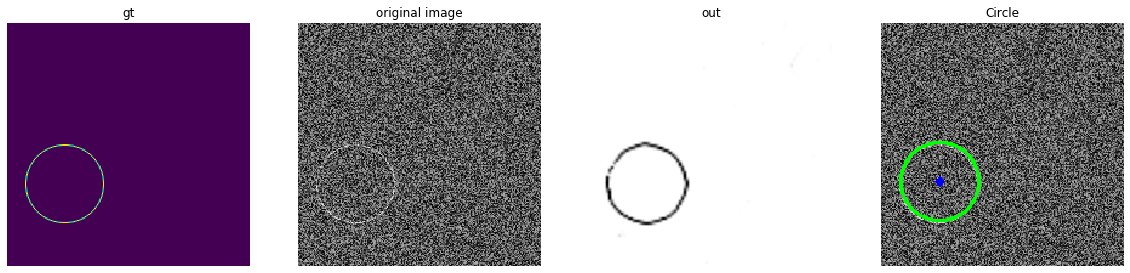

In [0]:
%mkdir res 
%rm res/*.png
# check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
from copy import deepcopy
imgs = []
success= 0
for img_idx in tqdm(range(data_amount-(int(100/batch_size)+1)*batch_size,data_amount)):
    # print("data/{:05d}.png".format(img_idx))
    img = cv2.imread("data/{:05d}.png".format(img_idx))
    try:
    # img  = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
      img_ = rgb2gray(img)
      img = img_
    except:
      pass
    # print(img.shape)
    imgs.append(img)
    input_img = torch.tensor(cv2.resize(img, (int(size/scale),int(size/scale ) ) )[None,None,:,:] )
    input_img = input_img.float().cuda()
    # print(input_img.size() )
    output_img = decoder(encoder(input_img))
    output_img = Double(output_img)
    inp = input_img.data.cpu().numpy()[0,0,:,:]
    out = output_img.data.cpu().numpy()[0,0,:,:]
    out = cv2.resize(out, (size,size))
    out =255-255*out/np.max(out)
    # print(np.max(out ))
    gt = gts_imgs[img_idx][0,:,:]
    # circles = cv2.HoughCircles(np.uint8(out),cv2.HOUGH_GRADIENT,1,20, param1=100,param2=80,minRadius=0,maxRadius=0)
    # circles = cv2.HoughCircles(np.uint8(out),cv2.HOUGH_GRADIENT,0.1,20, param1=200,param2=80,minRadius=0,maxRadius=0)
    # circles = cv2.HoughCircles(np.uint8(out),cv2.HOUGH_GRADIENT,1e-10,300)
    circles = cv2.HoughCircles(np.uint8(out),cv2.HOUGH_GRADIENT,1,20, param1=100,param2=30, minRadius = 0, maxRadius = 2*size)#,minRadius=0,maxRadius=0
    output = cv2.imread("data/{:05d}.png".format(img_idx))#cv2.resize(deepcopy(inp),(size,size))
    # ensure at least some circles were found
    if circles is not None:
      success+=1
      # convert the (x, y) coordinates and radius of the circles to integers
      # circles = np.round(circles[0, :]).astype("int")
      circles = np.uint16(np.around(circles))
    
      # loop over the (x, y) coordinates and radius of the circles
      for i in circles[0,:]:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output,(i[0],i[1]),i[2],(0,255,0),2)
      # draw the center of the circle
        cv2.circle(output,(i[0],i[1]),2,(0,0,255),3)

    fig, (Ax_gt, Ax_img, Ax_out,Ax_circle) = plt.subplots(1,4, figsize = (20, 8))
        
    Ax_gt.imshow(gt, interpolation='nearest')
    Ax_gt.axis('off')
    Ax_gt.set_title('gt')

    Ax_img.imshow(img, cmap='gray', interpolation='nearest')
    Ax_img.axis('off')
    Ax_img.set_title('original image')

    Ax_out.imshow(out, cmap='gray', interpolation='nearest')
    Ax_out.axis('off')
    Ax_out.set_title('out')

    Ax_circle.imshow(output, cmap='gray', interpolation='nearest')
    Ax_circle.axis('off')
    Ax_circle.set_title('Circle')
    fig.savefig("res/res_{:05d}.png".format(img_idx))
    # plt.show(output)
    if 0!= img_idx%50:
      plt.close()


In [0]:
print("success", success)
%ls res/* -alrth|wc -l

success 94
201


In [0]:

#!/usr/bin/env python
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))


zipf = zipfile.ZipFile('res.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('res/', zipf)
zipf.close()


from google.colab import files


files.download('res.zip')

In [0]:

#!/usr/bin/env python
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))


zipf = zipfile.ZipFile('model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('model/', zipf)
zipf.close()


from google.colab import files


files.download('model.zip')


In [0]:
# max_epoch = 160
# files.download('model/deno_autoencoder_circle_scale_{:03d}_new1_epoche_{:03d}.pkl'.format(scale,max_epoch))

In [0]:
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [0]:
# Encoder 
import torch.nn as nn
import torch
size = 200
batch_size = 100
scale = 4
Half = nn.Upsample(scale_factor=1/2, mode='bilinear')
Double = nn.Upsample(scale_factor=2, mode='bilinear')
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),  
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1), 
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32,64,3,padding=1),  
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
#         print("[encoder] out.size()",out.size())
        out = out.view(batch_size, -1)
        return out
    








# Decoder 

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding = 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,stride = 1,padding= 1),
                        nn.ReLU(),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(32,1,5,stride= 2,padding=1,output_padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2)

        )
        
    def forward(self,x):
        out = x.view(-1,64,int(size/scale),int(size/scale))
        out = self.layer1(out)
        out = self.layer2(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
import numpy as np
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
# from autoencoder import encoder, decoder, size, scale, device
import cv2, torch
def draw_circle(img, row, col, rad):
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def noisy_circle(size, radius, noise):
    img = np.zeros((size, size), dtype=np.float)
    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)
    # Noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img


def find_circle(img,idx):
    try:
      del out
    except:
      pass
    cv2.imwrite("temp_{:04d}.png".format(idx), img)
    input_img = torch.tensor(cv2.resize(img, (int(size/scale),int(size/scale ) ) )[None,None,:,:] )
    input_img = input_img.float()
    if 'cuda' == device.type:
        input_img = input_img.cuda()
    # print(input_img.size() )
    output_img = decoder(encoder(input_img))
    output_img = Double(output_img)
    inp = input_img.data.cpu().numpy()[0,0,:,:]
    inp = input_img.data.cpu().numpy()[0,0,:,:]
    out = output_img.data.cpu().numpy()[0,0,:,:]
    out = cv2.resize(out, (size,size))
    # output = img[:,None,None]
    # print('---------')
    output = cv2.imread("temp_{:04d}.png".format(idx))
    os.remove("temp_{:04d}.png".format(idx))
    out =255-255*out/np.max(out)
    circles = cv2.HoughCircles(np.uint8(out),cv2.HOUGH_GRADIENT,1,20, param1=100,param2=30, minRadius = 0, maxRadius = 2*size)#,minRadius=0,maxRadius=0
    # print("circles", circles)
    if circles is not None:
      # circles = np.round(circles[0, :]).astype("int")
      circles = np.uint16(np.around(circles))
      # Fill in this function
      # print(idx,[row,col,rad])
  
      row,col,rad = circles[0][0]
     
    else:
      row,col,rad = 100,100,30
# convert the (x, y) coordinates and radius of the circles to integers
    
    # draw the circle in the output image, then draw a rectangle
    # corresponding to the center of the circle
    cv2.circle(output,(row,col),rad,(0,255,0),2)
    # draw the center of the circle
    cv2.circle(output,(row,col),2,(0,0,255),3)

    fig, ( Ax_img, Ax_out,Ax_circle) = plt.subplots(1,3, figsize = (20, 8))
      
    # Ax_gt.imshow(gt, interpolation='nearest')
    # Ax_gt.axis('off')
    # Ax_gt.set_title('gt')

    Ax_img.imshow(img, cmap='gray', interpolation='nearest')
    Ax_img.axis('off')
    Ax_img.set_title('original image')

    Ax_out.imshow(out, cmap='gray', interpolation='nearest')
    Ax_out.axis('off')
    Ax_out.set_title('out')

    Ax_circle.imshow(output, cmap='gray', interpolation='nearest')
    Ax_circle.axis('off')
    Ax_circle.set_title('Circle')
    # print("type(idx)",idx)
    fig.savefig("res/res_{:04d}.png".format(idx))
    
    
    return row,col,rad
    

def iou(params0, params1):
    row0, col0, rad0 = params0
    row1, col1, rad1 = params1

    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)

    return (
        shape0.intersection(shape1).area /
        shape0.union(shape1).area
    )



In [0]:
results = []
model_paras_saved= 'model/deno_autoencoder_circle_new_epoche_{:03d}.pkl'.format(160)
if 'cuda' == device.type:
    encoder, decoder  =torch.load(model_paras_saved)
else:
    encoder, decoder  =torch.load(model_paras_saved, map_location=lambda storage, location: storage)
for idx in range(1000):
    params, img = noisy_circle(200, 50, 2)
    detected = find_circle(img,idx)
    # print(params,detected)
    results.append(iou(params, detected))
results = np.array(results)
print((results > 0.7).mean())


NameError: ignored

In [0]:
results = np.array(results)
print((results > 0.7).mean())